## Modeling fuel pellets in a PWR fuel rod

This notebook is intended to demonstrate the ``StackLattice`` class usage via creating a toy model of a PWR fuel rod. A PWR fuel rod consists of three components:
1. Fuel pellets
2. Cladding material
3. Cover gas injected into the gap in between the fuel pellets and cladding material

Fuel pellets also have gaps on their contact surfaces with each other

In [1]:
import openmc
model = openmc.model.Model()

## Defining Materials

We define our fuel (UO2) and moderator (water) materials:

In [2]:
uo2 = openmc.Material(name='UO2')
uo2.set_density('g/cm3', 10.0)
uo2.add_nuclide('U235', 1.0)
uo2.add_nuclide('O16', 2.0)
water = openmc.Material(name='light water')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

We also define the clad (zirconium) and the cover gas (helium) materials 

In [3]:
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
cover_gas = openmc.Material(name="cover gas")
cover_gas.add_element('He',1.0)
cover_gas.set_density('g/cm3', 0.00018)

With all of our materials defined, we add them to the model

In [4]:
model.materials.extend([uo2, water, zirconium, cover_gas])

Let's also define plot colors for vizualization

In [20]:
plot_colors={uo2: 'red', water: 'blue', cover_gas: 'green', zirconium: 'grey'}

## Defining Geometry
A typical fuel rod will have an active fuel length of 2-4 m. Let's assume our fuel rod has 200 fuel pellets. We'll also need 201 gap regions (199 for each contact surface between fuel pellets, and 2 for the contact surfaces between the fuel pellets and end plugs at each end of the fuel rod). We can say these gaps are a 1/100th of a millimeter.

We'll assume a fuel pellet height of 1.5cm, and take the rest of the dimensions from the Pincell tutorial/

In [11]:
n_pellets = 200
pellet_radius = 0.39
pellet_height = 1.5 # pellet height
contact_surface_gap_width = 0.0001
clad_inner_radius = 0.40
clad_outer_radius = 0.46

With our dimensions defined, we now create the necessary surfaces and cells

In [12]:
bottom = openmc.ZPlane(z0=0.)

pellet_outer = openmc.ZCylinder(r=pellet_radius)
pellet_top = openmc.ZPlane(z0=pellet_height)
pellet_region = -pellet_outer & -pellet_top & +bottom
pellet_void_region = +pellet_outer & -pellet_top & +bottom

gap_top = openmc.ZPlane(z0=contact_surface_gap_width)
contact_surface_gap_region = +bottom & -gap_top & -pellet_outer
contact_surface_gap_void_region = +bottom & -gap_top & +pellet_outer

fuel_pellet = openmc.Cell(fill=uo2, region=pellet_region)
fuel_pellet_void = openmc.Cell(region=pellet_void_region)
contact_surface_gap = openmc.Cell(fill=cover_gas, region=contact_surface_gap_region)
contact_surface_gap_void = openmc.Cell(region=contact_surface_gap_void_region)

fp = openmc.Universe(cells=[fuel_pellet, fuel_pellet_void])
ig = openmc.Universe(cells=[contact_surface_gap, contact_surface_gap_void])

Let's take a look at out pellet and gap regions:

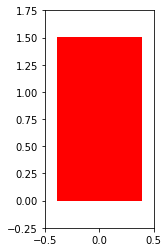

In [23]:
fp.plot(width=(1.,2.), 
              origin=(0.,0.,0.75), 
              basis='xz', 
              color_by='material', 
              colors=plot_colors)

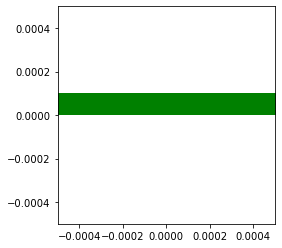

In [27]:
ig.plot(width=(0.001,0.001), 
              origin=(0.,0.,0.), 
              basis='xz', 
              color_by='material', 
              colors=plot_colors)

Now we actually go on to define our lattice. In this case, we have a nonuniform lattice strucutre.

In [14]:
univs = [ig, fp] * n_pellets
univs += [ig]
pellet_stack = openmc.StackLattice()
pellet_stack.central_axis = (0., 0.)
pellet_stack.base_coordinate = 0.
pellet_stack.universes = univs
pellet_stack.is_uniform = False
pitch = [contact_surface_gap_width, pellet_height] * n_pellets
pitch += [contact_surface_gap_width]
pellet_stack.pitch = pitch

stack_cell = openmc.Cell(fill=pellet_stack)

Now we need to add the pellet-to-clad gap, cladding, and water moderator

In [16]:
rod_top_coord = n_pellets * (pellet_height + contact_surface_gap_width) + contact_surface_gap_width
rod_top = openmc.ZPlane(z0=rod_top_coord)
                        
clad_inner = openmc.ZCylinder(r=clad_inner_radius)
clad_outer = openmc.ZCylinder(r=clad_outer_radius)
                        
clad_region = +clad_inner & -clad_outer & +bottom & -rod_top
clad_gap_region = +pellet_outer & -clad_inner & +bottom & -rod_top
water_region = ~(-clad_outer & +bottom & -rod_top)    

fuel_clad = openmc.Cell(fill=zirconium, region=clad_region)
clad_gap = openmc.Cell(fill=cover_gas, region=clad_gap_region)
water_reflector = openmc.Cell(fill=water, region=water_region)

Now we put everything together and add a boundary surface.

In [18]:
pin_univ = openmc.Universe(cells=[water_reflector,fuel_clad, clad_gap, stack_cell])

d = pellet_radius
box = openmc.model.RectangularParallelepiped(-clad_outer_radius -d, clad_outer_radius + d, 
                                             -clad_outer_radius -d, clad_outer_radius + d,
                                          0. - d, rod_top_coord + d,
                                          boundary_type='reflective')

main_cell = openmc.Cell(fill=pin_univ, region=-box)
model.geometry = openmc.Geometry(root=[main_cell])

Let's check how the ``pin_univ`` looks

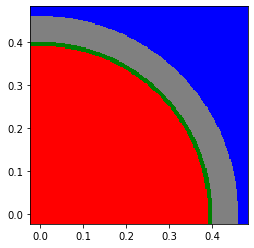

In [53]:
pin_univ.plot(width=(1.1*clad_outer_radius,1.1*clad_outer_radius), 
              origin=(0.5*clad_outer_radius,0.5*clad_outer_radius,0.75), 
              basis='xy', 
              color_by='material', 
              colors=plot_colors)

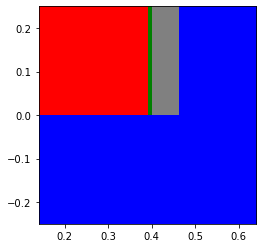

In [55]:
pin_univ.plot(width=(0.5,0.5), 
              origin=(.39,0.,0.), 
              basis='xz', 
              color_by='material', 
              colors=plot_colors)

They look good! All that's left is to create our settings, export the xmls, and run the model.

In [4]:
model.settings.batches = 10
model.settings.inactive = 5
model.settings.particles = 1000
model.settings.verbosity = 10

model.export_to_xml()

We can also define plots externally 

In [4]:
plotxy = openmc.Plot()
plotxy.basis = 'xy'
plotxy.origin = (0., 0., 1.)
plotxy.width = (5., 5.)
plotxy.pixels = (10000, 10000)
plotxy.color_by = 'material'

plotxy.colors = {
    uo2: 'red',
    water: 'blue',
    cover_gas: 'green',
    zirconium: 'grey'
    
}
plotxy.filename = 'xy'

plotxz = openmc.Plot()
plotxz.basis = 'xz'
plotxz.origin = (0., 0., 1.)
plotxz.width = (5., 5.)
plotxz.pixels = (10000, 10000)
plotxz.color_by = 'material'

plotxz.colors = {
    uo2: 'red',
    water: 'blue',
    cover_gas: 'green',
    zirconium: 'grey'
}
plotxz.filename = 'xz'

plots = openmc.Plots([plotxy, plotxz])
plots.export_to_xml()

And now we run our model

In [10]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

RuntimeError: Maximum number of lost particles has been reached. ERROR: Maximum number of lost particles has been reached. WARNING: Could not find the cell containing particle 586 WARNING: Could not find the cell containing particle 253